# Setup

In [ ]:
# stop Colab backend from disconnecting
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

SyntaxError: ignored

## Install and import libraries

In [ ]:
!pip3 install emnist
!pip3 install fastprogress
# !pip3 install matplotlib==3.3.2
# !pip3 install cleverhans

In [ ]:
from fastprogress import master_bar, progress_bar

import emnist

import numpy as np
import pandas as pd

import tensorflow as tf
import sklearn
import sklearn.metrics
import sklearn.model_selection

import matplotlib.pyplot as plt
import seaborn as sns


# from cleverhans.attacks import FastGradientMethod, BasicIterativeMethod
# from clevehans.utils_keras import KerasModelWrapper

## GPU Warmup

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def gpu_warmup():
  with tf.device('/device:GPU:0'):
    random_image = tf.random.normal((100,100,100,3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image)
    return tf.math.reduce_sum(net_gpu)

gpu_warmup()

Found GPU at: /device:GPU:0


<tf.Tensor: shape=(), dtype=float32, numpy=51.48636>

In [ ]:
# check which GPU you are using
gpu_attributes = tf.python.client.device_lib.list_local_devices()[-1]
print(gpu_attributes.physical_device_desc)

device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


## Mount Google Drive

Google Drive is mounted to take advantage of Google's *blazing* fast upload and download speeds to store the model and adversarial sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set Constants

In [ ]:
ROOT = '/content/drive/My Drive/Colab Notebooks'
STD_VALS = np.array(range(5, 40, 5)) / 100
SEED = 30034

In [ ]:
fp = ROOT + '/Data/emnist-balanced-mapping.txt'
ascii_class_mapping = pd.read_csv(fp, sep=' ', header=None,).set_index(keys=0).squeeze().apply(chr).to_dict()

# Load and Peek at data

In [ ]:
emnist.list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [ ]:
data_subset = 'balanced'
X_train, y_train = emnist.extract_training_samples(data_subset)
X_test, y_test = emnist.extract_test_samples(data_subset)

In [ ]:
TRAIN_SIZE = X_train.shape[0]
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
IMG_SHAPE = (WIDTH, HEIGHT)

In [ ]:
def show_9_samples(X, title=''):
  random_ids = np.random.randint(low=0, high=len(X), size=9)
  print('Randomly selected indices: ', random_ids)
  fig, axes = plt.subplots(3, 3)
  for id, ax in zip(random_ids, axes.ravel()):
    ax.imshow(X[id].reshape(IMG_SHAPE), cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  fig.suptitle(title)
  

Randomly selected indices:  [  1774  99530  31031 112429  40272  62080  43063  43036  78605]


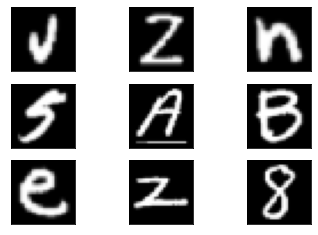

In [ ]:
show_9_samples(X_train)

In [ ]:
X_train_origin = X_train.reshape((X_train.shape[0], WIDTH, HEIGHT, 1)).astype('float32') / 255.0
X_test_origin = X_test.reshape((X_test.shape[0], WIDTH, HEIGHT, 1)).astype('float32') / 255.0
y_train_origin = tf.keras.utils.to_categorical(y_train)
y_test_origin = tf.keras.utils.to_categorical(y_test)

In [ ]:
INPUT_SHAPE = X_train_origin.shape[1:]
N_CLASSES = y_test_origin.shape[1]

# Initial CNN Model

## Define the model

In [64]:
def make_cnn_7conv_1dense(name):
    
    model = tf.keras.models.Sequential()

    model._name = name

    model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = INPUT_SHAPE))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
               
    model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
    
    adam = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(
        optimizer = adam, 
        loss = 'categorical_crossentropy', 
        metrics = [
          'accuracy',
          'Precision',
          'Recall',
        ]
    )
    
    return model

## Fit regular CNN on normal data

In [ ]:
# instantiate model
cnn = make_cnn_7conv_1dense(name='cnn_7conv_1dense')
cnn.summary()

In [ ]:
# train-validation split
X_train_origin_train, X_train_origin_validation, \
y_train_origin_train, y_train_origin_validation =\
sklearn.model_selection.train_test_split(
    X_train_origin,
    y_train_origin,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train,
)

In [ ]:
%%time

# define callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + cnn._name + '-checkpoint-ep{epoch:02d}-loss{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

# fit the Model
BATCH_SIZE = 1024,
history_cnn = cnn.fit(
    x=X_train_origin, 
    y=y_train_origin,
    # augmentation_generator.flow(
    #     X_train_origin_train, y_train_origin_train, 
    # ),
    # validation_data=(X_train_origin_validation, y_train_origin_validation),
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=1
)

# save the model and training history
model_name = cnn_7conv_1dense._name
cnn.save(ROOT+'/Models/'+ model_name)
pd.DataFrame(history_cnn.history).to_csv(ROOT+'/model_histories/'+ model_name + '_history.csv')

# evaluate accuracy
accuracy = cnn.evaluate(X_test_origin, y_test_origin, verbose=0)

print("Baseline Error: %.2f%%" % (100-accuracy[1]*100))
print(f'Test loss for base CNN: {accuracy[0]} / Test accuracy: {accuracy[1]}')

## Alternatively, load fitted model

In [ ]:
location = '/Models/sequential'

cnn = tf.keras.models.load_model(
    ROOT + location,
)

## Plot its learning curve

In [ ]:
def show_learning_curve(history, clf_name):

  with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots()

  sns.lineplot(
    data=pd.DataFrame(history.history),
    ax=ax,
    dashes=True,
    hue_order=[
      'accuracy',
      'val_accuracy',
      'loss',
      'val_loss',
    ],
    palette='mako',
  )

  ax.set_title(f'{clf_name} Learning Curve', size='xx-large', pad=10,)
  ax.set_xlabel('# epochs')
  ax.set_ylabel('Accuracy / Loss')

  return fig

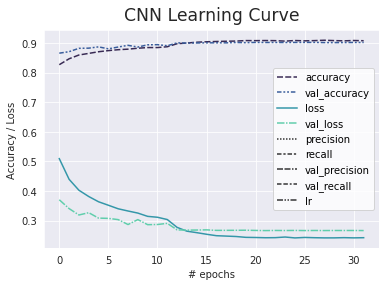

In [ ]:
regular_learning_fig =show_learning_curve(history=history_cnn)

## Confusion Matrix

In [ ]:
def show_confusion(model, X_eval, y_true, clf_desc, X_desc):

  # calculate confusion, precision and recal
  y_pred = model.predict_classes(X_eval)

  confusion_matrix = sklearn.metrics.confusion_matrix(
      y_true=y_true,
      y_pred=y_pred,
      normalize='true',
  )

  precision = sklearn.metrics.precision_score(
      y_true=y_true,
      y_pred=y_pred,
      average=None,
  )

  recall = sklearn.metrics.recall_score(
      y_true=y_true,
      y_pred=y_pred,
      average=None,
  )
  # set results into a dataframe
  marginals_df = pd.DataFrame({
    'class': ascii_class_mapping.values(),
    'precision': precision,
    'recall': recall,
  })

  # plot the confusion matrix
  with sns.axes_style('white'):
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(h=11, w=10)
    gs = fig.add_gridspec(
      nrows=3, ncols=2, width_ratios=[16,1], height_ratios=[1,16, 0.3],
      wspace=0.01, hspace=0.01
    )
    marg_x_ax = fig.add_subplot(gs[0, :-1])
    marg_y_ax = fig.add_subplot(gs[1:-1, -1])
    joint_ax = fig.add_subplot(gs[1:-1, 0:-1])
    cbar_ax = fig.add_subplot(gs[-1,:-1])

    default_color = sns.color_palette('mako', 50)[-1]
    accent_color = sns.color_palette('mako', 30)[-5]

    sns.barplot(
        data=marginals_df,
        y='precision',
        x='class',
        ax=marg_x_ax,
        color=default_color,
    )
    marg_x_ax.set_title('Precision', size='small')
    marg_x_ax.get_xaxis().set_visible(False)
    marg_x_ax.get_yaxis().set_visible(False)
    marg_x_ax.axhline(y=1, color=accent_color, dashes=(5,3), label='100%')
    sns.despine(ax=marg_x_ax, left=True, bottom=True)

    sns.barplot(
        data=marginals_df,
        x='recall',
        y='class',
        ax=marg_y_ax,
        color=default_color,
    )
    marg_y_ax.set_title('Recall', size='small')
    marg_y_ax.get_xaxis().set_visible(False)
    marg_y_ax.get_yaxis().set_visible(False)
    marg_y_ax.axvline(x=1, color=accent_color, dashes=(5,3), label='100%')
    sns.despine(ax=marg_y_ax, left=True, bottom=True)

    sns.heatmap(
        confusion_matrix,
        ax=joint_ax,
        xticklabels=ascii_class_mapping.values(),
        yticklabels=ascii_class_mapping.values(),
        cmap='mako_r',
        cbar=True,
        cbar_ax=cbar_ax,
        cbar_kws={
            'orientation': 'horizontal',
            'shrink' : 0.7,
            'fraction': 0.05,
            'aspect': 40,
        },
        annot=False,
        fmt='.1f',
        annot_kws={
            'alpha': 0.8,
            'fontsize': 10,
        },
        # square=True,
        linecolor='white',
        linewidth=0.004,
    )  
  joint_ax.tick_params(bottom=False, left=False, labeltop=True, labelright=True, labelrotation=0.0)
  joint_ax.set_ylabel('True class label', size='medium', labelpad=10)
  joint_ax.set_xlabel('Predicted class label', size='medium', labelpad=10)

  cbar_ax.set_xlabel('True proportion identified', size='small')
  fig.suptitle(f'{clf_desc} Confusion Matrix for {X_desc}', size='xx-large', va='top', )

  return fig

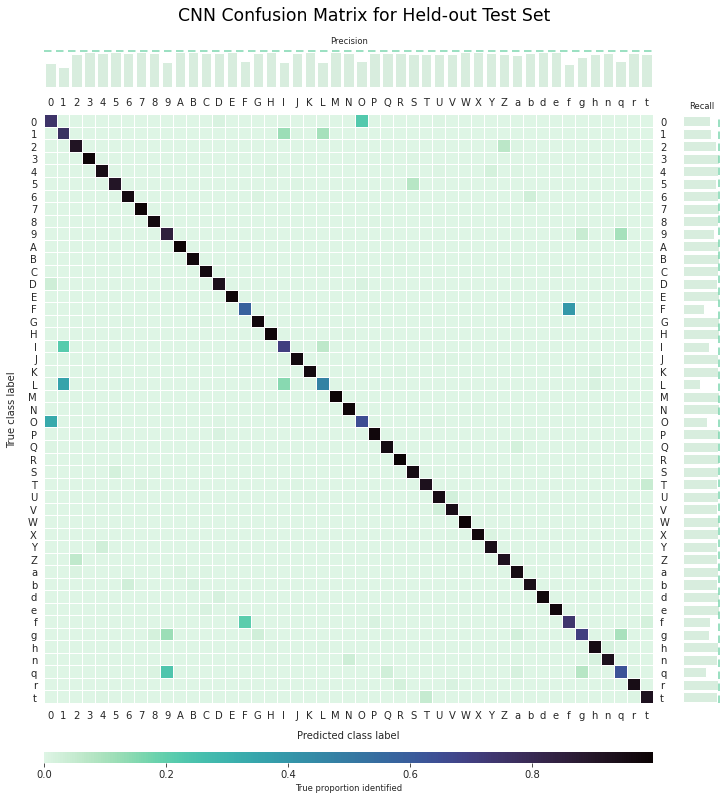

In [ ]:
fig = show_confusion(
    model=cnn, 
    X_eval=X_test_origin,
    y_true=y_test,
    clf_desc='CNN',
    X_desc='Held-out Test Set'
)

# Random noise adversary

## Create Noisy Datasets

### Noise-addition function def'ns

In [ ]:
def show_img_before_after(before, after, kind=''):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(before, cmap=plt.get_cmap('gray'))
    ax[0].set_title('Original')
    ax[1].imshow(after, cmap=plt.get_cmap('gray'))
    noisy_title = f'With {kind} Noise'
    ax[1].set_title(noisy_title)


In [ ]:
def add_gaussian_noise(original_img, sd=0.1):
  # add noise
  img_shape = original_img.shape
  original_img = original_img.copy()
  gauss = np.random.normal(0, sd, img_shape)
  new_img = original_img + gauss
  # rescale between 0-1
  img_min = new_img.min()
  img_max = new_img.max()
  new_img = (new_img - img_min) / (img_max - img_min)
  return new_img

In [ ]:
def add_speckle_noise(original_img):
  img_shape = original_img.shape
  original_img = original_img.copy()
  if img_shape.count == 3:
    row, col, ch = img_shape
    guass = np.random.randn(row, col, ch)
    guass = guass.reshape(row, col, ch)
    noisy_img = original_img + original_img*guass
  else:
    guass = np.random.normal(0, 1, img_shape)
    noisy_img = original_img + original_img*guass
  # rescale between 0-1
  img_min = noisy_img.min()
  img_max = noisy_img.max()
  noisy_img = (noisy_img - img_min) / (img_max - img_min)
  return noisy_img

In [ ]:
def add_impulse_noise(img, signal_noise, salt_pepper_ratio=0.5):
  shape = img.shape
  img = img.copy()
  unif = np.random.uniform(low=0, high=1, size=shape)
  total_noise = 1-signal_noise

  salt_amount = total_noise * salt_pepper_ratio
  salted = np.where(unif<salt_amount, 1, img)

  pepper_amount = total_noise * (1-salt_pepper_ratio)
  peppered = np.where(unif>1-pepper_amount, 0, salted)
  
  return peppered

### Preview generate-able noise types

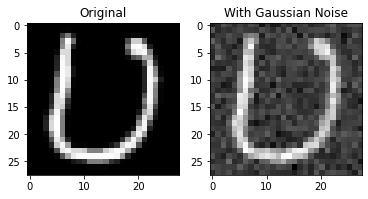

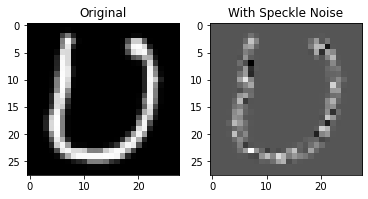

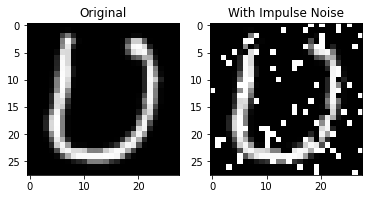

In [ ]:
# demo
img = X_train_origin[103728]
show_img_before_after(img.reshape((28, 28)), add_gaussian_noise(img, 0.10).reshape((28, 28)), kind='Gaussian')
show_img_before_after(img.reshape((28, 28)), add_speckle_noise(img).reshape((28, 28)), kind='Speckle')
show_img_before_after(img.reshape((28, 28)), add_impulse_noise(img, 0.8).reshape((28, 28)), kind='Impulse')

### Create and save the Gaussian examples

In [ ]:
def add_gauss_to_data(std_range, X_original, name):
  std_range = np.array(std_range)
  sd_names =  [f'{int(val*100):02}' for val in std_range]

  for i, sd in enumerate(std_range): 
    X_gauss = np.zeros(shape=X_original.shape)
    
    for j, img in enumerate(X_original):
      X_gauss[j] = add_gaussian_noise(img, sd=sd)

    fname = f'X_{name}_gauss_{sd_names[i]}'
    print(fname)
    np.save(ROOT + f'/Adversarial_Data/{fname}', X_gauss)

In [ ]:
%%time
add_gauss_to_data(
    std_range=np.array([0.3]), 
    X_original=X_test_origin, 
    name='test'
)

X_test_gauss_30
CPU times: user 1.11 s, sys: 73.5 ms, total: 1.19 s
Wall time: 1.51 s


In [ ]:
%%time
add_gauss_to_data(STD_VALS, X_train_origin, 'train')

X_train_gauss_05
X_train_gauss_10
X_train_gauss_15
X_train_gauss_20
X_train_gauss_25
X_train_gauss_30
X_train_gauss_35
CPU times: user 51.5 s, sys: 4.34 s, total: 55.8 s
Wall time: 1min 41s


### Create and save impulse examples

In [ ]:
def add_impulse_to_data(X_original, snr_range, store_dir):

  snrs_fp_suffixes = [f'{int(snr*100):02}' for snr in snr_range]

  for i, snr in progress_bar(list(enumerate(snr_range))):
    X_impulse = np.zeros(shape=X_original.shape)

    for j, img in master_bar(list(enumerate(X_original))):
      X_impulse[j] = add_impulse_noise(img, snr)
  
    fname = store_dir + f'_{snrs_fp_suffixes[i]}'
    print(fname)
    np.save(fname, X_impulse)
                         
                         

In [ ]:
%%time 
IMPULSE_SNRS = np.arange(0.75, 1, 0.05)
add_impulse_to_data(
    X_original=X_test_origin, 
    snr_range=IMPULSE_SNRS,
    store_dir=ROOT + '/Adversarial_Data/X_test_impulse'
)

/content/drive/My Drive/Colab Notebooks/Adversarial_Data/X_test_impulse_75


/content/drive/My Drive/Colab Notebooks/Adversarial_Data/X_test_impulse_80


/content/drive/My Drive/Colab Notebooks/Adversarial_Data/X_test_impulse_85


/content/drive/My Drive/Colab Notebooks/Adversarial_Data/X_test_impulse_90


/content/drive/My Drive/Colab Notebooks/Adversarial_Data/X_test_impulse_95
CPU times: user 3.26 s, sys: 392 ms, total: 3.65 s
Wall time: 5.27 s


In [ ]:
%%time 
IMPULSE_SNRS = np.arange(0.75, 1, 0.05)
add_impulse_to_data(
    X_original=X_train_origin, 
    snr_range=IMPULSE_SNRS,
    store_dir=ROOT + '/Adversarial_Data/X_train_impulse'
)

## Load the datasets

In [ ]:
def load_adv(vals, X_subset, adv_type, X_dict=None):
  
  if not bool(X_dict):
    X_dict = dict()

  fp_vals = [f'{int(val*100):02}' for val in vals]
  
  for std_val, fp_val in progress_bar(list(zip(vals, fp_vals))):
    print(std_val, fp_val)
    X_dict[std_val] = np.load(ROOT + f'/Adversarial_Data/X_{X_subset}_{adv_type}_{fp_val}.npy') 
  
  return X_dict

In [ ]:
def load_gaussian(std_vals, name, X_dict=None):
  
  if not bool(X_dict):
    X_dict = dict()

  stds = [f'{int(val*100):02}' for val in std_vals]
  
  for std_val, std in zip(std_vals, stds):
    print(std_val, std)
    X_dict[std_val] = np.load(ROOT + f'/Adversarial_Data/X_{name}_gauss_{std}.npy') 
  
  return X_dict

In [ ]:
# load the attack examples (test examples) with Gauss noise

X_test_gauss_d = load_gaussian(std_vals=STD_VALS, name='test')
X_test_gauss_d[0.00] = X_test_origin

0.05 05
0.1 10
0.15 15
0.2 20
0.25 25
0.3 30
0.35 35


In [ ]:
X_train_gauss_d = load_gaussian(std_vals=np.array([0.35]), name='train')
X_train_gauss_d[0.00] = X_train_origin

0.35 35


In [ ]:
X_test_impulse_d = load_adv(
    vals=IMPULSE_SNRS,
    X_subset='test',
    adv_type='impulse',
)
X_test_impulse_d[1.0] = X_test_origin

0.75 75
0.8 80
0.8500000000000001 85
0.9000000000000001 90
0.9500000000000002 95


In [ ]:
X_train_impulse_d = load_adv(
    vals=[0.75],
    X_subset='train',
    adv_type='impulse',
)
# X_train_impulse_d[1.0] = X_train_origin

0.75 75


## Peek at loaded examples

In [ ]:
def show_noise_levels(X_dict, nth_img, title='noise'):
  fig, axes = plt.subplots(ncols=len(X_dict))
  for i, (std, X) in enumerate(sorted(X_dict.items())):
    axes[i].imshow(X[nth_img].reshape((28,28)), cmap=plt.get_cmap('gray'))
    axes[i].set_title(f'{title}: {std:0.2}')
    axes[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
  fig.set_size_inches(w=10, h=2)
  sns.despine(fig)
  return fig

In [ ]:
fig = show_noise_levels(X_test_gauss_d, np.random.randint(low=0, high=(len(X_test_gauss_d[0]))))

NameError: ignored

Text(0.5, 0.98, 'Sample Impulse Noise Examples')

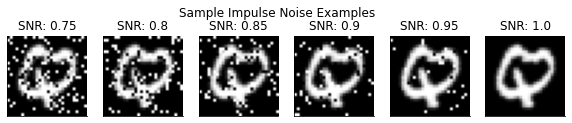

In [ ]:
fig = show_noise_levels(
    X_test_impulse_d, 
    np.random.randint(low=0, high=(len(X_test_impulse_d[1.0]))),
    title='SNR'
)
fig.suptitle('Sample Impulse Noise Examples')

## Gaussian Noise Attack

In [ ]:
def plot_degradation(df, model_name, attack_name, xlabel):
  with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots()
  
  sns.lineplot(
      data=df,
      x='var',
      y='value',
      hue='variable',
      hue_order = ['accuracy', 'precision', 'recall'],
      ax=ax,
      palette='mako'
  )
  ax.set_title(f'{model_name} under {attack_name} Attack', size='xx-large', pad=10)
  ax.set_xlabel(xlabel)
  fig.set_size_inches(h=8, w=10)
  return fig


In [55]:
def attack(model, X_test_d, y_true, attack_name, model_name, xlabel):

  degradation = dict()

  for epsilon, noisy_test_set in X_test_d.items():

    results = model.evaluate(
        x=noisy_test_set,
        y=y_true,
        return_dict=True,
    )

    degradation[epsilon] = results

  # degradation_df = pd.DataFrame.from_dict(degradation, orient='index')
  # degradation_df.index.name='epsilon'

  degradation_df = pd.DataFrame(degradation).transpose().reset_index().rename(columns={'index': 'var'})
  degradation_df = pd.melt(
      degradation_df, 
      id_vars=['var'],
      value_vars=list(results.keys())
  )
  return degradation_df, plot_degradation(degradation_df, model_name, attack_name, xlabel)


588/588 [==============================] - 3s 5ms/step - loss: 0.2802 - accuracy: 0.9021 - precision: 0.9154 - recall: 0.8896


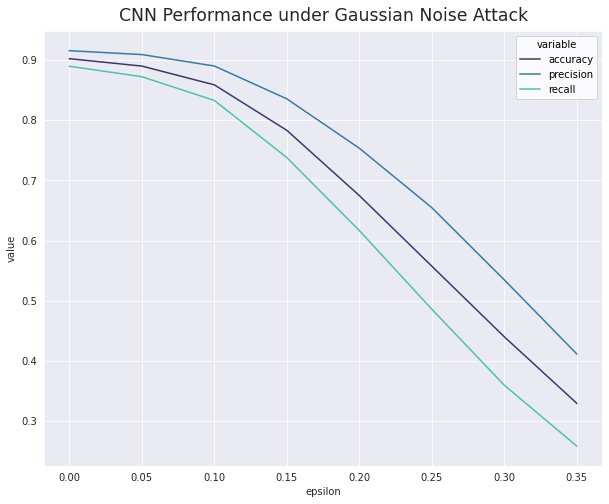

In [ ]:
gaussian_attack_df, gaussian_attack_fig = attack(
    model=cnn,
    X_test_d=X_test_gauss_d,
    y_true=y_test_origin,
    attack_name='Gaussian Noise',
    model_name='CNN',
    xlabel="epsilon"
)

In [59]:
gaussian_attack_df.to_csv(ROOT + '/attacks/guassian_attack.csv')
gaussian_attack_df = pd.read_csv(ROOT + '/attacks/guassian_attack.csv')

## Impulse Noise Attack

In [ ]:
impulse_attack_df, impulse_attack_fig = attack(
    model=cnn,
    X_test_d=X_test_impulse_d,
    y_true=y_test_origin,
    attack_name='Impulse Noise',
    model_name='CNN',
    xlabel="Signal Noise Ratio"
)

impulse_attack_df.to_csv(ROOT + '/attacks/impulse_attack.csv')

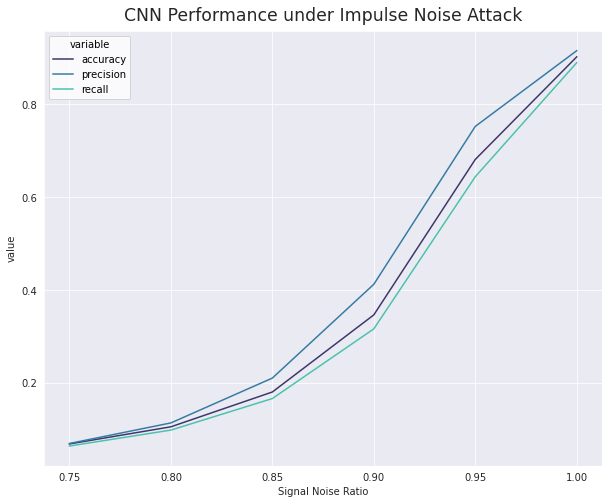

In [ ]:
impulse_attack_fig

## Gaussian Adv-training Defence

### Fit the model

In [ ]:
cnn_gaussian_defence = make_cnn_7conv_1dense('cnn_7conv_1dense_gaussian_defence')
cnn_gaussian_defence.summary()

Model: "cnn_7conv_1dense_gaussian_defence"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (Non

In [ ]:
%%time

# define callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + cnn_gaussian_defence._name + '-checkpoint-ep{epoch:02d}-loss{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

# fit the Model
BATCH_SIZE = 1024,
cnn_gaussian_defence_learning_history = cnn_gaussian_defence.fit(
    x=X_train_gauss_d[0.35], 
    y=y_train_origin,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=1
)

# save the model and training history
model_name = cnn_gaussian_defence._name
cnn_gaussian_defence.save(ROOT+'/Models/'+ model_name)
pd.DataFrame(history_cnn.history).to_csv(ROOT+'/model_histories/'+ model_name + '_history.csv')

# evaluate scores
scores = cnn_gaussian_defence.evaluate(X_test_origin, y_test_origin, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print(f'Test loss for base CNN: {scores[0]} / Test scores: {scores[1]}')

Epoch 1/50
2819/2820 [============================>.] - ETA: 0s - loss: 0.5737 - accuracy: 0.8069 - precision: 0.8601 - recall: 0.7610
Epoch 00001: val_accuracy improved from -inf to 0.84145, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_gaussian_defence-checkpoint-ep01-loss0.44
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_gaussian_defence-checkpoint-ep01-loss0.44/assets
2820/2820 [==============================] - 22s 8ms/step - loss: 0.5736 - accuracy: 0.8069 - precision: 0.8601 - recall: 0.7610 - val_loss: 0.4427 - val_accuracy: 0.8414 - val_precision: 0.8784 - val_recall: 0.8091
Epoch 2/50
2815/2820 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.8255 - precision: 0.8698 - recall: 0.7853
Epoch 00002: val_accuracy improved from 0.84145 to 0.85284, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_gaussian_defence-checkpoint-ep02-loss0.40
INFO:

### Alternatively, load fitted model

In [80]:
location = '/Models/cnn_7conv_1dense_gaussian_defence'

cnn_gaussian_defence = tf.keras.models.load_model(
    ROOT + location,
)

### Learning curves

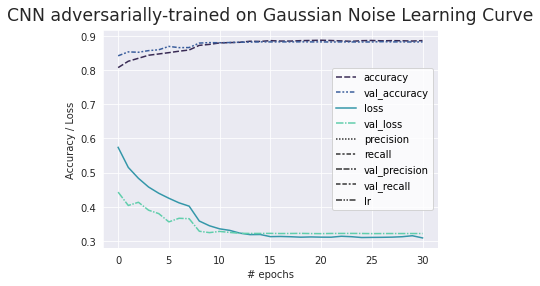

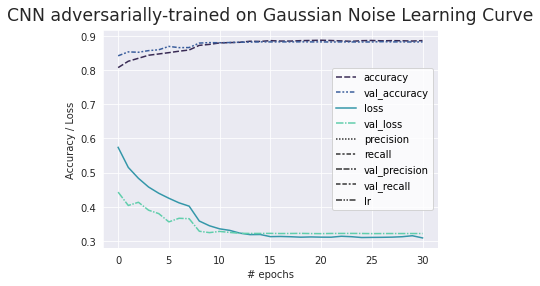

In [ ]:
show_learning_curve(
    cnn_gaussian_defence_learning_history, 
    clf_name='CNN adversarially-trained on Gaussian Noise'
)

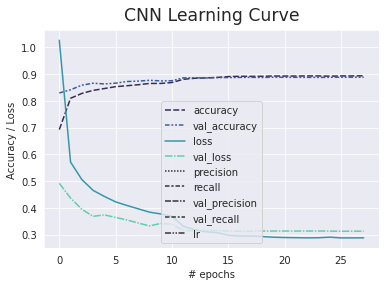

In [ ]:
with sns.axes_style('darkgrid'):

  fig, ax = plt.subplots()
  sns.lineplot(
    data=cnn_gaussian_defence_learning_history.history,
    ax=ax,
    dashes=True,
    # dashes=[False, True, False, True,False, True],
    hue_order=[
      'accuracy',
      'val_accuracy',
      'loss',
      'val_loss',
      # 'lr',
    ],
    palette='mako',
  )

  ax.set_title('CNN Learning Curve', size='xx-large', pad=10,)
  ax.set_xlabel('# epochs')
  ax.set_ylabel('Accuracy / Loss')

### Confusion Matrix

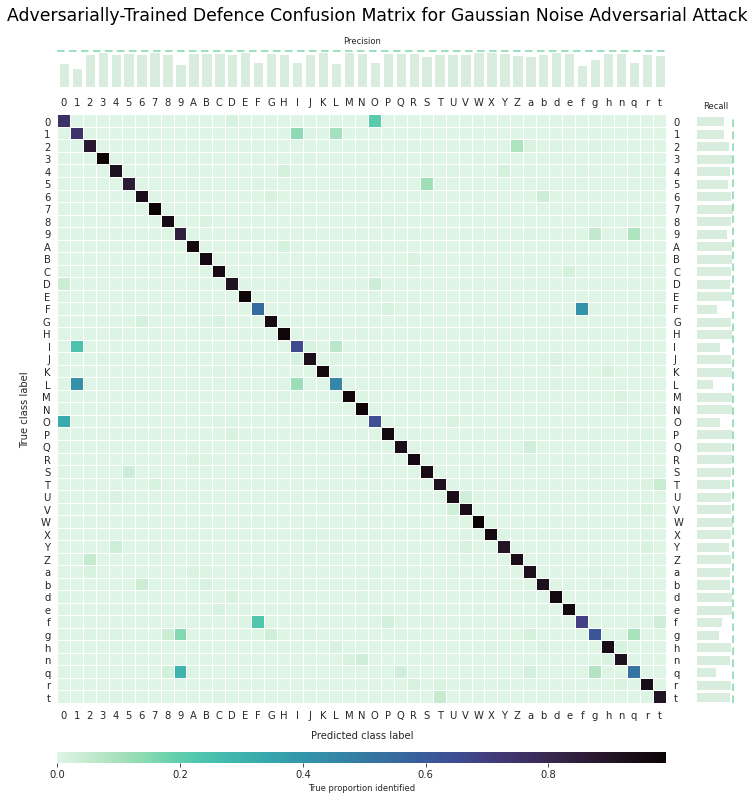

In [ ]:
fig = show_confusion(
    model=cnn_gaussian_defence, 
    X_eval=X_test_gauss_d[0.35], 
    y_true=y_test, 
    clf_desc='Adversarially-Trained Defence', 
    X_desc='Gaussian Noise Adversarial Attack'
)

### Attack on adversarially-trained model

588/588 [==============================] - 3s 5ms/step - loss: 0.3240 - accuracy: 0.8852 - precision: 0.9012 - recall: 0.8729


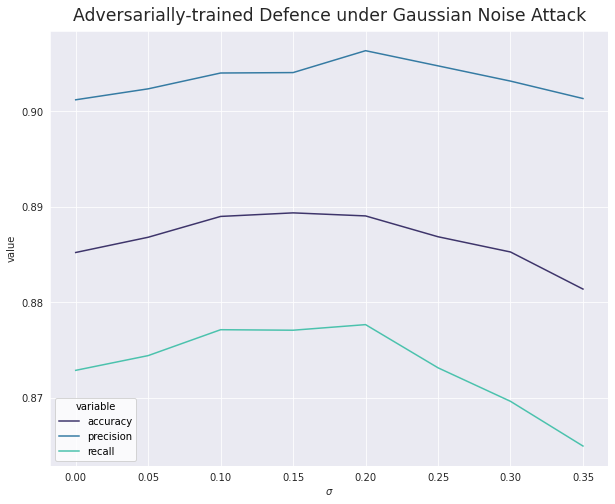

In [ ]:
gauss_defence_df, guass_defence_fig = attack(
    model=cnn_gaussian_defence,
    X_test_d=X_test_gauss_d,
    y_true=y_test_origin,
    attack_name='Gaussian Noise',
    model_name='Adversarially-trained Defence',
    xlabel=r'$\sigma$'
)
gauss_defence_df.to_csv(ROOT + '/attacks/gaussian_defence.csv')

588/588 [==============================] - 3s 4ms/step - loss: 0.3240 - accuracy: 0.8852 - precision_2: 0.9012 - recall_2: 0.8729


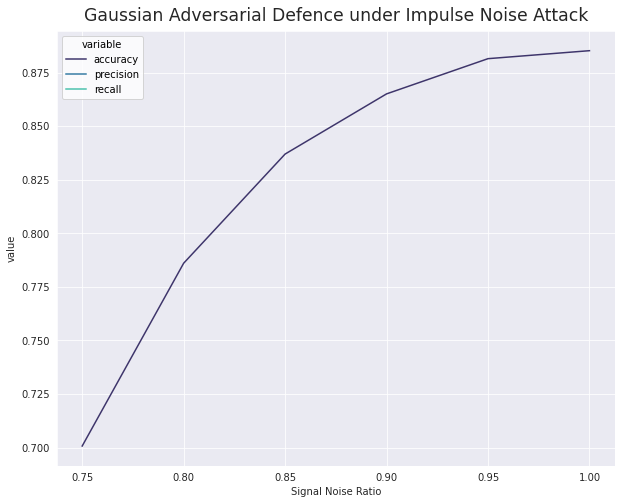

In [81]:
gauss_defence_on_impulse_df, guass_defence_on_impulse_fig = attack(
    model=cnn_gaussian_defence,
    X_test_d=X_test_impulse_d,
    y_true=y_test_origin,
    attack_name='Impulse Noise',
    model_name='Gaussian Adversarial Defence',
    xlabel=r'Signal Noise Ratio'
)
gauss_defence_on_impulse_df.to_csv(ROOT + '/attacks/gaussian_defence_under_impulse.csv')

## Impulse Adv-training Defence

### Fit the model

In [ ]:
cnn_impulse_defence = make_cnn_7conv_1dense('cnn_7conv_1dense_impulse_defence')
cnn_impulse_defence.summary()

Model: "cnn_7conv_1dense_impulse_defence"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None

In [ ]:
%%time

# define callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + cnn_impulse_defence._name + '-checkpoint-ep{epoch:02d}-loss{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

# fit the Model
BATCH_SIZE = 1024,
cnn_impulse_defence_learning_history = cnn_impulse_defence.fit(
    x=X_train_impulse_d[0.75], 
    y=y_train_origin,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=1
)

# save the model and training history
model_name = cnn_impulse_defence._name
cnn_impulse_defence.save(ROOT+'/Models/'+ model_name)
pd.DataFrame(cnn_impulse_defence_learning_history.history).to_csv(ROOT+'/model_histories/'+ model_name + '_history.csv')

# evaluate scores
scores = cnn_impulse_defence.evaluate(X_test_impulse_d[0.75], y_test_origin, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print(f'Test loss for base CNN: {scores[0]} / Test scores: {scores[1]}')

Baseline Error: 10.54%
Test loss for base CNN: 0.30482786893844604 / Test scores: 0.8945744633674622


### Alternatively, load fitted model

In [ ]:
location = '/Models/cnn_7conv_1dense_impulse_defence'

cnn_impulse_defence = tf.keras.models.load_model(
    ROOT + location,
)

### Learning curves

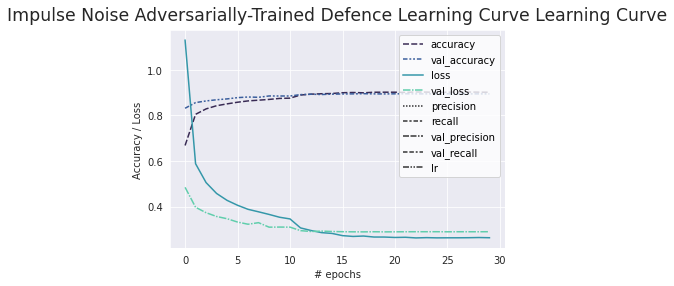

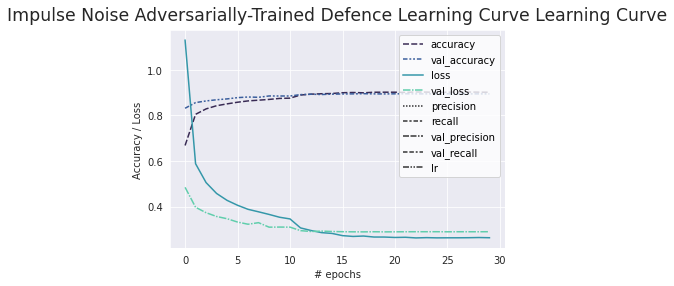

In [ ]:
show_learning_curve(
    cnn_impulse_defence_learning_history, 
    clf_name='Impulse Noise Adversarially-Trained Defence Learning Curve'
)

### Confusion Matrix

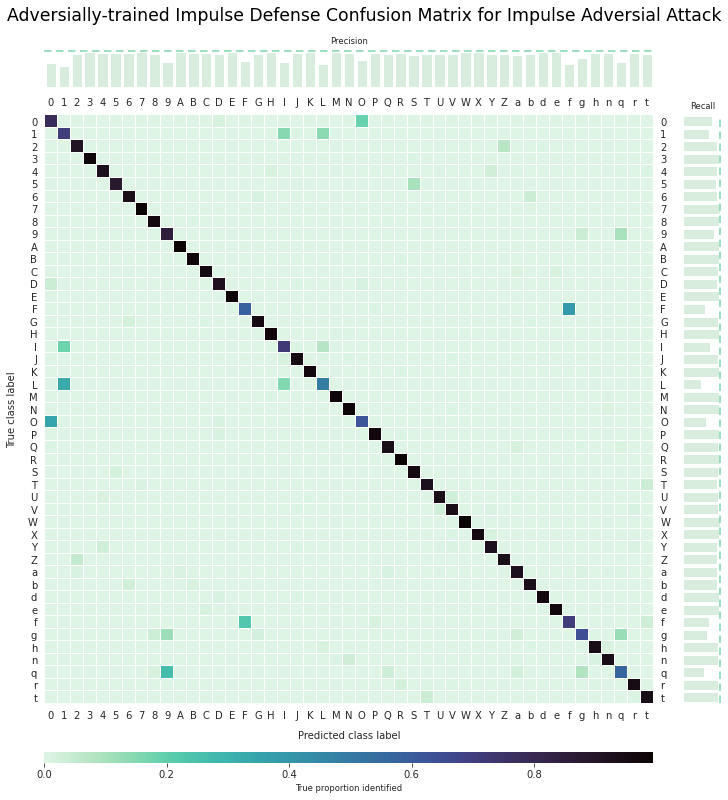

In [ ]:
confusion_fig = show_confusion(
    model=cnn_impulse_defence, 
    X_eval=X_test_impulse_d[0.75], 
    y_true=y_test, 
    clf_desc='Adversially-trained Impulse Defense', 
    X_desc='Impulse Adversial Attack'
)

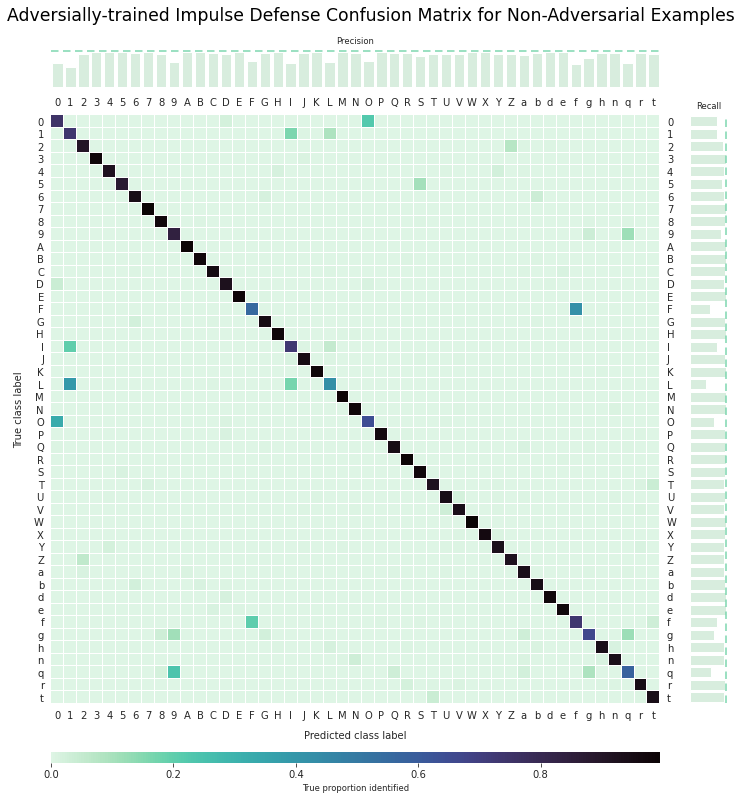

In [ ]:
confusion_fig = show_confusion(
    model=cnn_impulse_defence, 
    X_eval=X_test_origin, 
    y_true=y_test, 
    clf_desc='Adversially-trained Impulse Defense', 
    X_desc='Non-Adversarial Examples'
)

### Attack on adversarially-trained model

588/588 [==============================] - 3s 5ms/step - loss: 0.3010 - accuracy: 0.8947 - precision_1: 0.9077 - recall_1: 0.8830


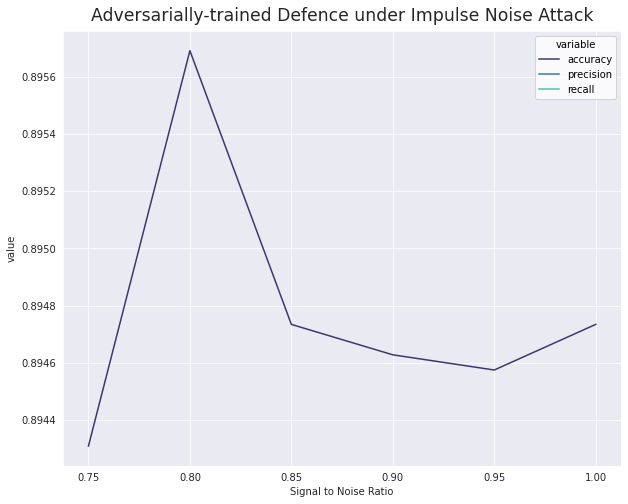

In [54]:
impulse_defence_df, impulse_defence_fig = attack(
    model=cnn_impulse_defence,
    X_test_d=X_test_impulse_d,
    y_true=y_test_origin,
    attack_name='Impulse Noise',
    model_name='Adversarially-trained Defence',
    xlabel=r'Signal to Noise Ratio',
)
impulse_defence_df.to_csv(ROOT + '/attacks/impulse_defence.csv')

In [ ]:
impulse_defence_under_gauss_df, impulse_defence_fig = attack(
    model=cnn_impulse_defence,
    X_test_d=X_test_gauss_d,
    y_true=y_test_origin,
    attack_name='Gaussian Noise',
    model_name='Impulse-Noise Adversarially-trained Defence',
    xlabel=r'$\sigma$'
)
impulse_defence_under_gauss_df.to_csv(ROOT + '/attacks/impulse_defence_under_gaussian.csv')

# FGSM Adversary

In [ ]:
cnn.trainable = False

## Show process

In [ ]:
image = X_test_origin[0].reshape((1,28,28,1))
image_probs = cnn.predict(image)

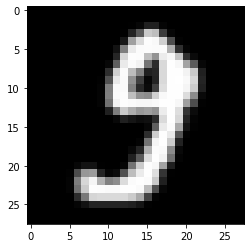

In [ ]:
plt.imshow(image.reshape((28,28)), cmap=plt.get_cmap('gray'))

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
  input_image = tf.convert_to_tensor(input_image)
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss= loss_object(input_label, prediction)
  
  # get gradient of loss w.r.t image
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
label = y_test_origin[0].reshape((1,47))
perturbations = create_adversarial_pattern(image, label, cnn).numpy()

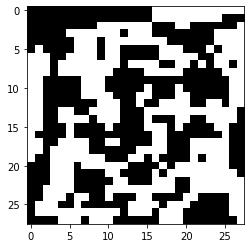

In [ ]:
plt.imshow((perturbations).reshape((28,28)), cmap=plt.get_cmap('gray'))

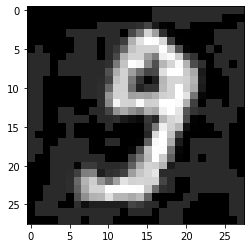

In [ ]:
plt.imshow((image + 0.1 *perturbations).reshape((28,28)), cmap=plt.get_cmap('gray'))

## Create adversarial examples on original CNN

In [ ]:
def create_fgsm(model, X, y, store_dir, description):
  
  fgsm_perturbation = np.zeros(shape=X.shape)

  for i, img in progress_bar(list(enumerate(X))):
    img = np.expand_dims(img, 0)
    lbl = np.expand_dims(y[i], 0)
    fgsm_perturbation[i] = create_adversarial_pattern(img, lbl, model)
  fname = store_dir + f'/{description}_fgsm_from_{model._name}'
  np.save(fname, fgsm_perturbation)
  return fgsm_perturbation

In [ ]:
%%time
X_test_fgsm_perturbs = create_fgsm(
    model=cnn,
    X=X_test_origin, 
    y=y_test_origin,
    store_dir=ROOT + '/Adversarial_Data/',
    description='X_test'
)

CPU times: user 4min 13s, sys: 2.7 s, total: 4min 16s
Wall time: 4min 12s


In [ ]:
def add_perturbations(epsilons, perturbations, X, X_dict=None, normalise=False):
  if not bool(X_dict):
    X_dict = dict()
  
  if normalise:
    norm = 1
  else:
    norm = (np.sqrt(13) - 1)/2
  for eps in epsilons:
    X_dict[eps] = X + eps * perturbations * norm # normalizing factor so each FGSM pixel has roughly same variance as Gaussian for the same epsilon
  
  X_dict[0.0] = X
  return X_dict

In [ ]:
epsilons = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

X_test_fgsm_d = add_perturbations(epsilons, X_test_fgsm_perturbs, X_test_origin)

## Peek at generated examples

Randomly selected indices:  [11532  6001 12241 18507 14638  5523  7348  5390 14867]


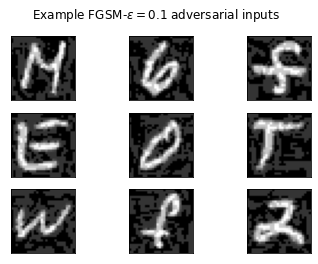

In [ ]:
show_9_samples(X_test_fgsm_d[0.1], title=r'Example FGSM-$\epsilon=0.1$ adversarial inputs')

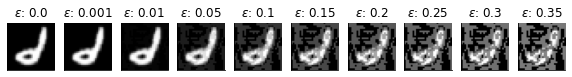

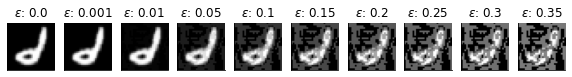

In [ ]:
show_noise_levels(X_test_fgsm_d, nth_img=123, title=r'$\epsilon$')

## Load adversarial examples

In [ ]:
perturbs = np.load(ROOT + f'/Adversarial_Data/X_test_fgsm_from_cnn_7conv_1dense.npy')

In [57]:
epsilons = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

X_test_fgsm_d = add_perturbations(epsilons, perturbs, X_test_origin, normalise=True)

## FGSM attack

588/588 [==============================] - 3s 5ms/step - loss: 0.2802 - accuracy: 0.9021 - precision: 0.9154 - recall: 0.8896


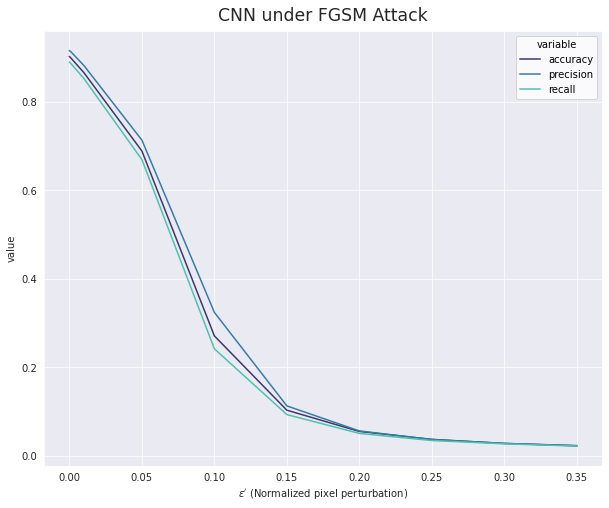

In [62]:
fgsm_attack_df, fgsm_attack_fig = attack(
    model=cnn,
    X_test_d=X_test_fgsm_d,
    y_true=y_test_origin,
    attack_name='FGSM',
    model_name='CNN',
    xlabel=r"$\epsilon'$ (Normalized pixel perturbation)"
)

In [ ]:
fgsm_attack_df.to_csv(ROOT+'/attacks/fgsm_attack.csv')
fgsm_attack_df = pd.read_csv(ROOT+'/attacks/fgsm_attack.csv')

,Unnamed: 0,var,variable,value
0,0,0.001,loss,0.292113
1,1,0.010,loss,0.416157
2,2,0.050,loss,1.441710
3,3,0.100,loss,7.889174
4,4,0.150,loss,15.255693
5,5,0.200,loss,22.453695
6,6,0.250,loss,29.727747
7,7,0.300,loss,37.128788
8,8,0.350,loss,44.658386
9,9,0.000,loss,0.280185


# FGSM Adversarial Training Defense

## Create FGSM training examples

In [ ]:
%%time
X_train_fgsm_perturbs = create_fgsm(
    model=cnn,
    X=X_train_origin, 
    y=y_train_origin,
    store_dir=ROOT + '/Adversarial_Data/',
    description='X_train'
)

CPU times: user 26min 40s, sys: 22.8 s, total: 27min 3s
Wall time: 26min 54s


Randomly selected indices:  [102441  81394  99069  72683 100498  27502   9314  25809  81549]


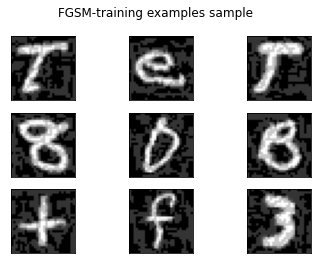

In [ ]:
X_train_fgsm_d = add_perturbations([0.1], X_train_fgsm_perturbs, X_train_origin)
show_9_samples(X_train_fgsm_d[0.1], title='FGSM-training examples sample')

## Train the model

In [ ]:
cnn_fgsm_defence = make_cnn_7conv_1dense('cnn_7conv_1dense_fgsm_defence')
cnn_fgsm_defence.summary()

Model: "cnn_7conv_1dense_fgsm_defence"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1

In [ ]:
%%time

# define callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + cnn_fgsm_defence._name + '-checkpoint-ep{epoch:02d}-loss{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

# fit the Model
BATCH_SIZE = 1024,
cnn_fgsm_defence_learning_history = cnn_fgsm_defence.fit(
    x=X_train_fgsm_d[0.1], 
    y=y_train_origin,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=1
)

# save the model and training history
model_name = cnn_fgsm_defence._name
cnn_fgsm_defence.save(ROOT+'/Models/'+ model_name)
pd.DataFrame(cnn_fgsm_defence_learning_history.history).to_csv(ROOT+'/model_histories/'+ model_name + '_history.csv')

# evaluate scores
scores = cnn_fgsm_defence.evaluate(X_test_fgsm_d[0.1], y_test_origin, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print(f'Test loss for base CNN: {scores[0]} / Test scores: {scores[1]}')

Epoch 1/50
2819/2820 [============================>.] - ETA: 0s - loss: 0.7521 - accuracy: 0.7994 - precision: 0.9131 - recall: 0.7256
Epoch 00001: val_accuracy improved from -inf to 0.95887, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_fgsm_defence-checkpoint-ep01-loss0.15
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_fgsm_defence-checkpoint-ep01-loss0.15/assets
2820/2820 [==============================] - 28s 10ms/step - loss: 0.7519 - accuracy: 0.7994 - precision: 0.9131 - recall: 0.7257 - val_loss: 0.1540 - val_accuracy: 0.9589 - val_precision: 0.9726 - val_recall: 0.9500
Epoch 2/50
2818/2820 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9379 - precision: 0.9573 - recall: 0.9237
Epoch 00002: val_accuracy improved from 0.95887 to 0.97238, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_fgsm_defence-checkpoint-ep02-loss0.10
INFO:tensorflow:

## Alternatively, load fitted model

In [ ]:
location = '/Models/cnn_7conv_1dense_fgsm_defence'

cnn_fgsm_defence = tf.keras.models.load_model(
    ROOT + location,
)

### Learning curves

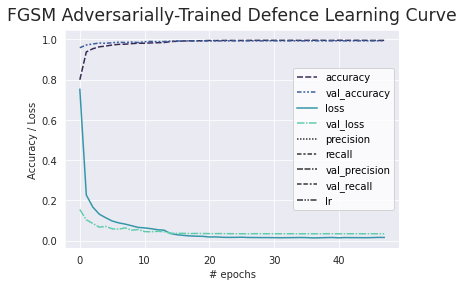

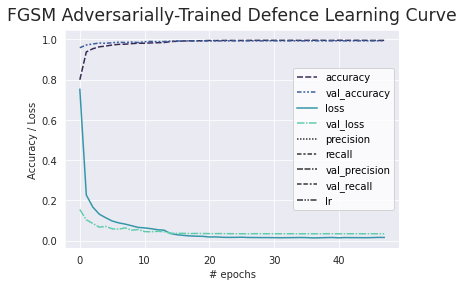

In [ ]:
show_learning_curve(
    cnn_fgsm_defence_learning_history, 
    clf_name='FGSM Adversarially-Trained Defence'
)

### Confusion Matrix

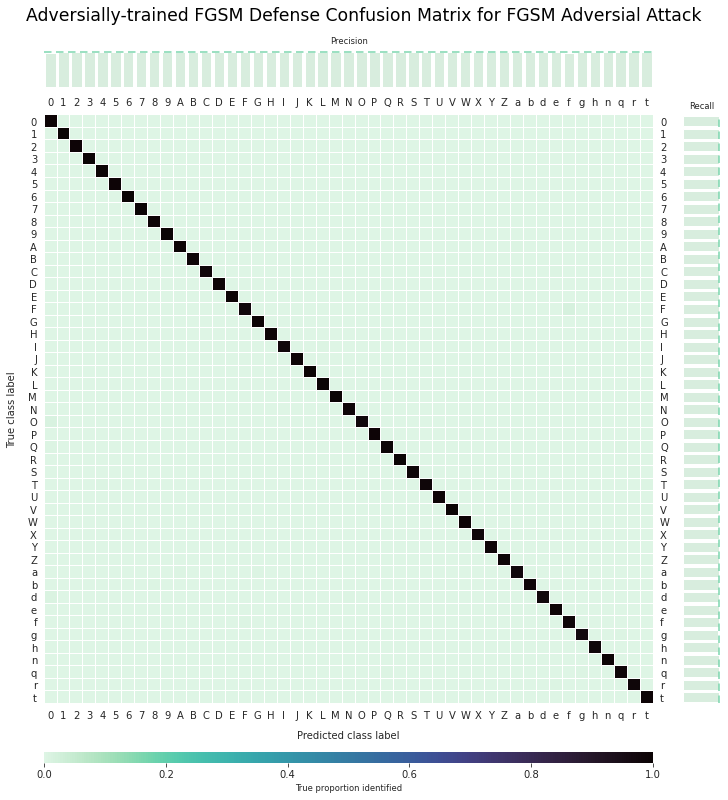

In [ ]:
confusion_fig = show_confusion(
    model=cnn_fgsm_defence, 
    X_eval=X_test_fgsm_d[0.1],
    y_true=y_test, 
    clf_desc='Adversially-trained FGSM Defense', 
    X_desc='FGSM Adversial Attack'
)

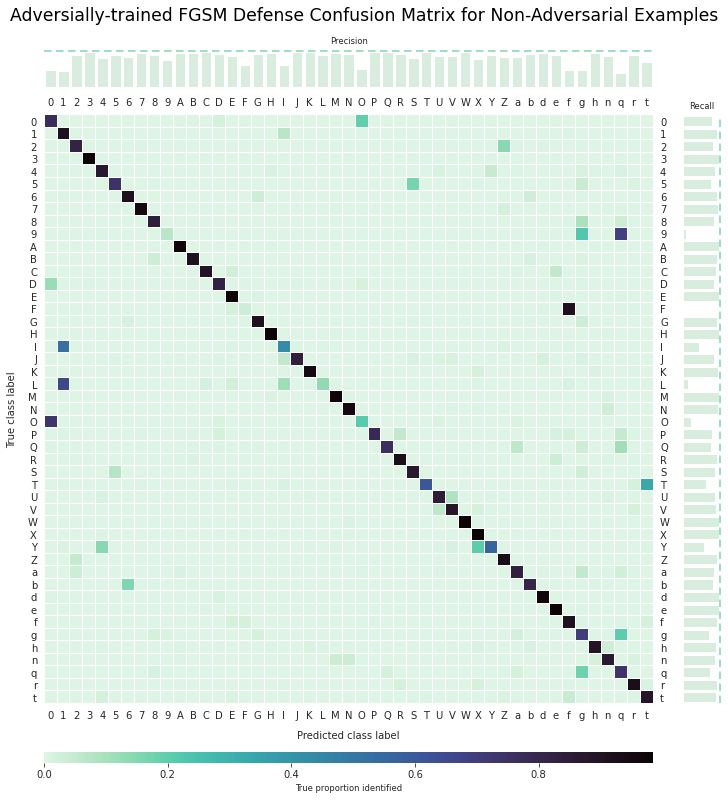

In [ ]:
confusion_fig = show_confusion(
    model=cnn_fgsm_defence, 
    X_eval=X_test_origin, 
    y_true=y_test, 
    clf_desc='Adversially-trained FGSM Defense', 
    X_desc='Non-Adversarial Examples'
)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


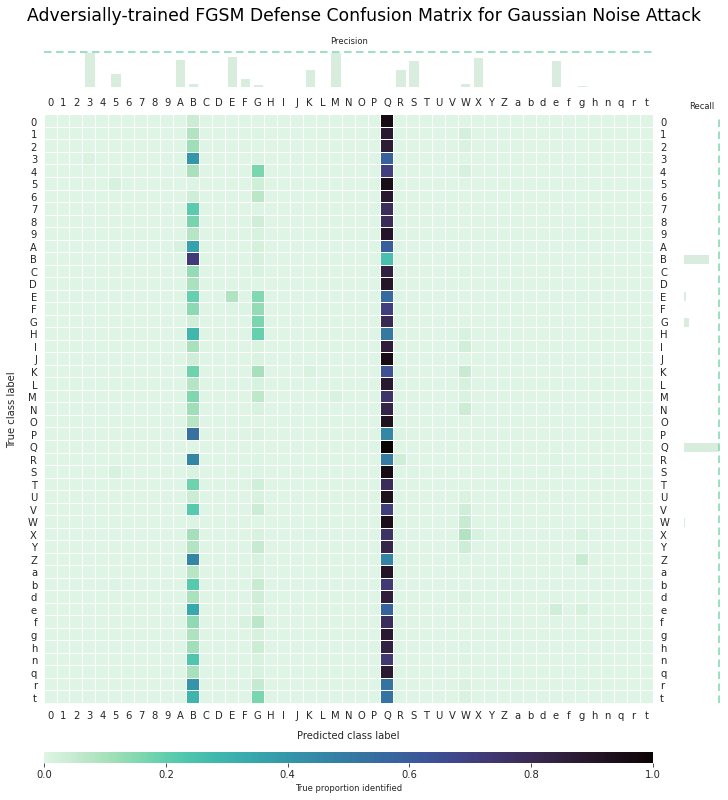

In [ ]:
confusion_fig = show_confusion(
    model=cnn_fgsm_defence, 
    X_eval=X_test_gauss_d[0.35], 
    y_true=y_test, 
    clf_desc='Adversially-trained FGSM Defense', 
    X_desc='Gaussian Noise Attack'
)

## Attack

### Attack with original FGSM examples

588/588 [==============================] - 3s 4ms/step - loss: 0.9085 - accuracy: 0.7997 - precision: 0.8090 - recall: 0.7931


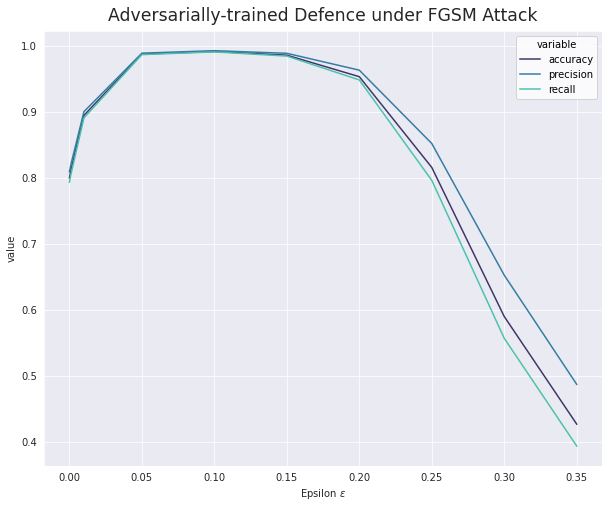

In [ ]:
fgsm_defence_df, fgsm_defence_fig = attack(
    model=cnn_fgsm_defence,
    X_test_d=X_test_fgsm_d,
    y_true=y_test_origin,
    attack_name='FGSM',
    model_name='Adversarially-trained Defence',
    xlabel=r'Epsilon $\epsilon$'
)
fgsm_defence_df.to_csv(ROOT + '/attacks/fgsm_defence.csv')

### Attack with new FGSM examples generated from adv-clf

#### Create new FGSM test examples

In [ ]:
cnn_fgsm_defence.trainable = False

In [ ]:
%%time
X_retest_fgsm_perturbs = create_fgsm(
    model=cnn_fgsm_defence,
    X=X_test_origin, 
    y=y_test_origin,
    store_dir=ROOT + '/Adversarial_Data/',
    description='X_retest_for_defence'
)

CPU times: user 4min 13s, sys: 3.86 s, total: 4min 17s
Wall time: 4min 16s


In [ ]:
X_retest_fgsm_d = add_perturbations(epsilons, X_retest_fgsm_perturbs, X_test_origin)
show_noise_levels(X_retest_fgsm_d, nth_img=123, title=r'$\epsilon$')

NameError: ignored

588/588 [==============================] - 3s 5ms/step - loss: 0.9085 - accuracy: 0.7997 - precision: 0.8090 - recall: 0.7931


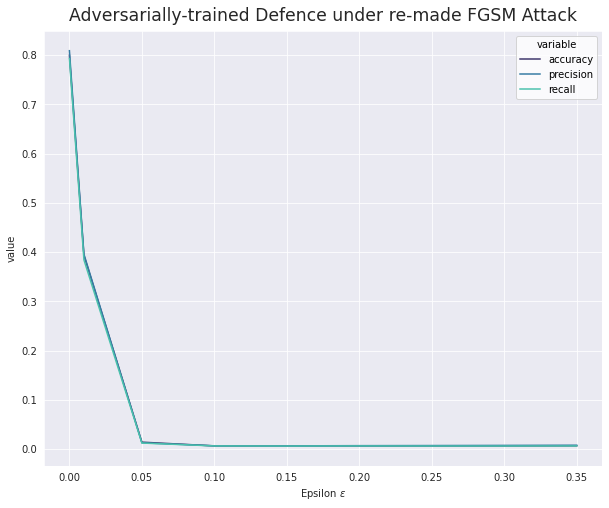

In [ ]:
fgsm_defence_attack_df, fgsm_defence_attack_fig = attack(
    model=cnn_fgsm_defence,
    X_test_d=X_retest_fgsm_d,
    y_true=y_test_origin,
    attack_name='re-made FGSM',
    model_name='Adversarially-trained Defence',
    xlabel=r'Epsilon $\epsilon$'
)
fgsm_defence_attack_df.to_csv(ROOT + '/attacks/fgsm_defence_attack.csv')

588/588 [==============================] - 3s 5ms/step - loss: 0.3010 - accuracy: 0.8947 - precision: 0.9077 - recall: 0.8830


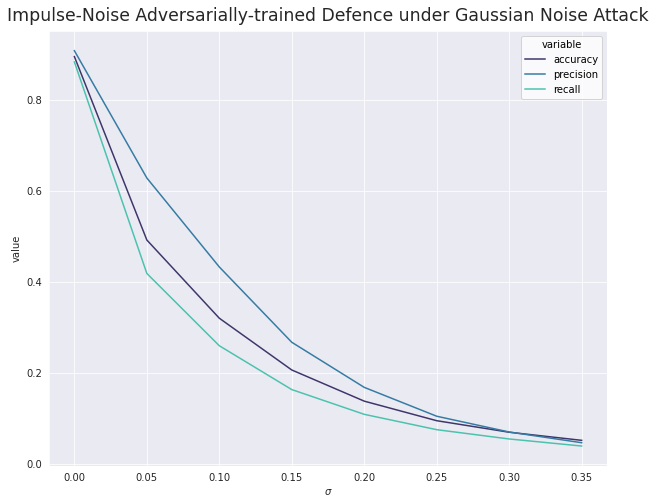

In [ ]:
impulse_defence_df, impulse_defence_fig = attack(
    model=cnn_impulse_defence,
    X_test_d=X_test_gauss_d,
    y_true=y_test_origin,
    attack_name='Gaussian Noise',
    model_name='Impulse-Noise Adversarially-trained Defence',
    xlabel=r'$\sigma$'
)
gauss_defence_df.to_csv(ROOT + '/attacks/impulse_defence_under_gaussian.csv')

# FGSM Randomized Shifting Defense

## Visualize random shifting

In [67]:
random_shifter = tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='constant',
    cval=0,
    # height_shift_range=4,
    # width_shift_range=4,
    zoom_range=[1.05, 1.3],
    data_format='channels_last'
)

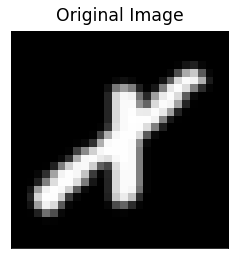

In [ ]:
original_img = X_train_origin[100]

fig, ax = plt.subplots()
ax.imshow(original_img.reshape(IMG_SHAPE), cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Original Image', size='xx-large', pad=10)
samples = np.expand_dims(original_img, 0)

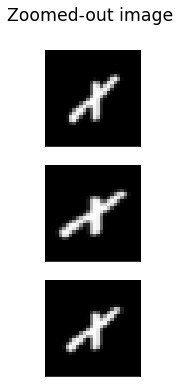

In [ ]:
zoomer = tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='constant',
    cval=0,
    zoom_range=[1.05, 1.5],
    data_format='channels_last'
)
iter = zoomer.flow(samples, batch_size=1, shuffle=False, seed=SEED)

zoomed_samples = []
fig, axes = plt.subplots(nrows=3)
for i, _ in enumerate(axes):
  batch = iter.next()
  image = batch[0]
  zoomed_samples.append(image)
  _.imshow(
      image.reshape(IMG_SHAPE), 
      cmap=plt.get_cmap('gray'),
  )
  _.get_xaxis().set_visible(False)
  _.get_yaxis().set_visible(False)
fig.suptitle('Zoomed-out image', size='xx-large')
fig.set_size_inches(h=6, w=2.5)
# fig.tight_layout()
zoomed_samples = np.array(zoomed_samples)
plt.show()

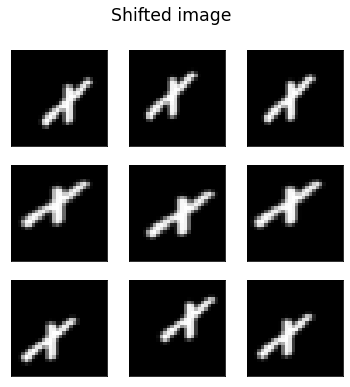

In [ ]:
shifter = tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='constant',
    cval=0,
    height_shift_range=4,
    width_shift_range=4,
    data_format='channels_last'
)
iter = shifter.flow(zoomed_samples, batch_size=1, seed=SEED, shuffle=False)
final_samples = []

fig, axes = plt.subplots(nrows=3, ncols=3)
for ax in axes.ravel(order='F'):
  batch = iter.next()
  image = batch[0]
  final_samples.append(image)
  ax.imshow(
      image.reshape(IMG_SHAPE), 
      cmap=plt.get_cmap('gray'),
  )
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
fig.suptitle('Shifted image', size='xx-large')
fig.set_size_inches(h=6, w=6)
# fig.tight_layout()
plt.show()


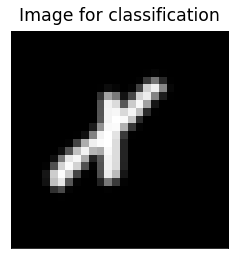

In [ ]:
fig, ax = plt.subplots()
ax.imshow(final_samples[3].reshape(IMG_SHAPE), cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Image for classification', size='xx-large', pad=10)
samples = np.expand_dims(original_img, 0)

In [ ]:


iter = random_shifter.flow(samples, batch_size=2)

for i in range(9):
  plt.subplot(330 + 1 + i)
  batch = iter.next()
  image = batch[0]
  plt.imshow(
      image.reshape((28,28)), 
      cmap=plt.get_cmap('gray'),
  )
plt.show()

## Defense

In [ ]:
fgsm_degradation = dict()

shift_range = [0,2,4]
top_zoom_range = [1.0, 1.1, 1.2]
epsilon_range = [0, 0.1, 0.2]

for eps in epsilon_range:
  
  fgsm_degradation[eps] = dict()

  for shift in shift_range:

    fgsm_degradation[eps][shift] = dict()
    
    for zoom_upper in top_zoom_range:

      random_shifter = tf.keras.preprocessing.image.ImageDataGenerator(
        fill_mode='constant',
        cval=0,
        height_shift_range=shift,
        width_shift_range=shift,
        zoom_range=[1.0, zoom_upper],
        data_format='channels_last'
      ) 

      result = cnn.evaluate(
          random_shifter.flow(X_test_fgsm_d[eps], y_test_origin),
          return_dict=True,
      )

      fgsm_degradation[eps][shift][zoom_upper] = result

fgsm_degradation_df = pd.DataFrame.from_dict(
    {
        (eps, shift, zoom_upper): fgsm_degradation[eps][shift][zoom_upper]
        for eps in fgsm_degradation.keys()
        for shift in fgsm_degradation[eps].keys()
        for zoom_upper in fgsm_degradation[eps][shift].keys()
    },
    orient='index',
)
fgsm_degradation_df.index.names = ['epsilon', 'shift', 'zoom_upper']

588/588 [==============================] - 7s 11ms/step - loss: 17.1457 - accuracy: 0.0397 - precision: 0.0399 - recall: 0.0362


In [ ]:
fgsm_degradation_df.to_csv(ROOT+'/attacks/fgsm_randomized_defence_1.csv')
fgsm_degradation_df = pd.read_csv(ROOT+'/attacks/fgsm_randomized_defence_1.csv')

No handles with labels found to put in legend.


[None, None, None, None, None, None, None, None]

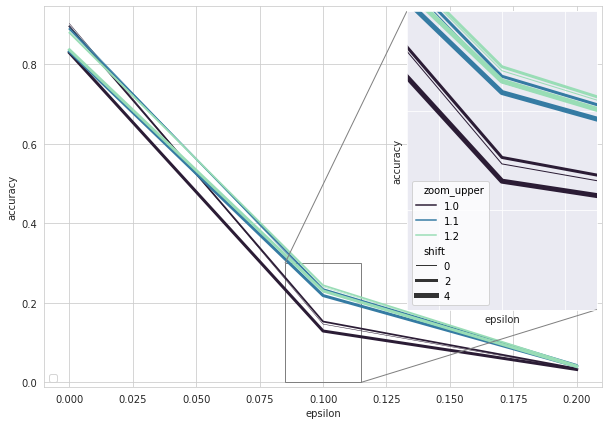

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots()
fig.set_size_inches(h=7, w=10)
sns.lineplot(
    x='epsilon',
    y='accuracy',
    hue='zoom_upper',
    style='shift',
    markers=False,
    dashes=False,
    size='shift',
    sizes=(0.5, 3),
    ax=ax,
    palette=sns.color_palette('mako', 7)[0:7:3],
    data=fgsm_degradation_df,
    legend=False,
)
ax.legend(loc='lower left')

with sns.axes_style('darkgrid'):
  axins = zoomed_inset_axes(ax, zoom=2.5, loc='upper right')

sns.lineplot(
    x='epsilon',
    y='accuracy',
    hue='zoom_upper',
    style='shift',
    markers=False,
    dashes=False,
    size='shift',
    sizes=(1, 5),
    ax=axins,
    palette=sns.color_palette('mako', 7)[0:7:3],
    data=fgsm_degradation_df,
    legend=True,
)


axins.set_xlim(left=0.085, right=0.115)
axins.set_ylim(top=0.3, bottom=0.00)
axins.yaxis.get_major_locator().set_params(nbins=4)
axins.xaxis.get_major_locator().set_params(nbins=4)

mark_inset(ax, axins,loc1=2,loc2=4, fc='none',ec='0.5')

plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)

(0.0, 0.3)

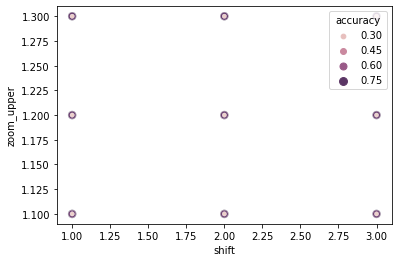

In [ ]:
sns.scatterplot(
    data=fgsm_degradation_df,
    x='shift',
    y='zoom_upper',
    hue='accuracy',
    size='accuracy'
)

## Retrain with augmentation

## Fit regular CNN on normal data

In [65]:
# instantiate model
cnn_fgsm_aug_defence = make_cnn_7conv_1dense(name='cnn_fgsm_aug_defence')
cnn.summary()

Model: "cnn_7conv_1dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)   

In [66]:
# train-validation split
X_train_origin_train, X_train_origin_validation, \
y_train_origin_train, y_train_origin_validation =\
sklearn.model_selection.train_test_split(
    X_train_origin,
    y_train_origin,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train,
)

In [72]:
%%time

# define callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + cnn_fgsm_aug_defence._name + '-checkpoint-ep{epoch:02d}-loss{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

# fit the Model
BATCH_SIZE = 1024,
history_cnn_fgsm_aug_defence = cnn.fit(
    # x=X_train_origin, 
    # y=y_train_origin,
    random_shifter.flow(
        X_train_origin_train, y_train_origin_train, 
    ),
    validation_data=(X_train_origin_validation, y_train_origin_validation),
    # validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=1
)

# save the model and training history
model_name = cnn._name
cnn.save(ROOT+'/Models/'+ model_name)
pd.DataFrame(history_cnn_fgsm_aug_defence.history).to_csv(ROOT+'/model_histories/'+ model_name + '_history.csv')

# evaluate accuracy
# accuracy = cnn.evaluate(X_test_origin, y_test_origin, verbose=0)
accuracy = cnn.evaluate(random_shifter.flow(
        X_test_origin, y_test_origin, 
    ), verbose=0)

print("Baseline Error: %.2f%%" % (100-accuracy[1]*100))
print(f'Test loss for base CNN: {accuracy[0]} / Test accuracy: {accuracy[1]}')

Baseline Error: 12.09%
Test loss for base CNN: 0.3277113437652588 / Test accuracy: 0.8791489601135254


## Alternatively, load fitted model

In [73]:
location = '/Models/cnn_7conv_1dense'

cnn_fgsm_aug_defence = tf.keras.models.load_model(
    ROOT + location,
)

## Plot its learning curve

In [76]:
show_learning_curve(history=history_cnn_fgsm_aug_defence)

TypeError: ignored

## Confusion Matrix

In [ ]:
def show_confusion(model, X_eval, y_true, clf_desc, X_desc):

  # calculate confusion, precision and recal
  y_pred = model.predict_classes(X_eval)

  confusion_matrix = sklearn.metrics.confusion_matrix(
      y_true=y_true,
      y_pred=y_pred,
      normalize='true',
  )

  precision = sklearn.metrics.precision_score(
      y_true=y_true,
      y_pred=y_pred,
      average=None,
  )

  recall = sklearn.metrics.recall_score(
      y_true=y_true,
      y_pred=y_pred,
      average=None,
  )
  # set results into a dataframe
  marginals_df = pd.DataFrame({
    'class': ascii_class_mapping.values(),
    'precision': precision,
    'recall': recall,
  })

  # plot the confusion matrix
  with sns.axes_style('white'):
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(h=11, w=10)
    gs = fig.add_gridspec(
      nrows=3, ncols=2, width_ratios=[16,1], height_ratios=[1,16, 0.3],
      wspace=0.01, hspace=0.01
    )
    marg_x_ax = fig.add_subplot(gs[0, :-1])
    marg_y_ax = fig.add_subplot(gs[1:-1, -1])
    joint_ax = fig.add_subplot(gs[1:-1, 0:-1])
    cbar_ax = fig.add_subplot(gs[-1,:-1])

    default_color = sns.color_palette('mako', 50)[-1]
    accent_color = sns.color_palette('mako', 30)[-5]

    sns.barplot(
        data=marginals_df,
        y='precision',
        x='class',
        ax=marg_x_ax,
        color=default_color,
    )
    marg_x_ax.set_title('Precision', size='small')
    marg_x_ax.get_xaxis().set_visible(False)
    marg_x_ax.get_yaxis().set_visible(False)
    marg_x_ax.axhline(y=1, color=accent_color, dashes=(5,3), label='100%')
    sns.despine(ax=marg_x_ax, left=True, bottom=True)

    sns.barplot(
        data=marginals_df,
        x='recall',
        y='class',
        ax=marg_y_ax,
        color=default_color,
    )
    marg_y_ax.set_title('Recall', size='small')
    marg_y_ax.get_xaxis().set_visible(False)
    marg_y_ax.get_yaxis().set_visible(False)
    marg_y_ax.axvline(x=1, color=accent_color, dashes=(5,3), label='100%')
    sns.despine(ax=marg_y_ax, left=True, bottom=True)

    sns.heatmap(
        confusion_matrix,
        ax=joint_ax,
        xticklabels=ascii_class_mapping.values(),
        yticklabels=ascii_class_mapping.values(),
        cmap='mako_r',
        cbar=True,
        cbar_ax=cbar_ax,
        cbar_kws={
            'orientation': 'horizontal',
            'shrink' : 0.7,
            'fraction': 0.05,
            'aspect': 40,
        },
        annot=False,
        fmt='.1f',
        annot_kws={
            'alpha': 0.8,
            'fontsize': 10,
        },
        # square=True,
        linecolor='white',
        linewidth=0.004,
    )  
  joint_ax.tick_params(bottom=False, left=False, labeltop=True, labelright=True, labelrotation=0.0)
  joint_ax.set_ylabel('True class label', size='medium', labelpad=10)
  joint_ax.set_xlabel('Predicted class label', size='medium', labelpad=10)

  cbar_ax.set_xlabel('True proportion identified', size='small')
  fig.suptitle(f'{clf_desc} Confusion Matrix for {X_desc}', size='xx-large', va='top', )

  return fig

### Attack

588/588 [==============================] - 3s 5ms/step - loss: 0.2884 - accuracy: 0.8999 - precision: 0.9124 - recall: 0.8895


(      var   variable      value
 0   0.001       loss   0.297911
 1   0.010       loss   0.396380
 2   0.050       loss   1.057806
 3   0.100       loss   4.844516
 4   0.150       loss  10.517620
 5   0.200       loss  15.999512
 6   0.250       loss  21.341700
 7   0.300       loss  26.664761
 8   0.350       loss  32.014263
 9   0.000       loss   0.288435
 10  0.001   accuracy   0.896596
 11  0.010   accuracy   0.862606
 12  0.050   accuracy   0.678830
 13  0.100   accuracy   0.254255
 14  0.150   accuracy   0.100638
 15  0.200   accuracy   0.055266
 16  0.250   accuracy   0.036968
 17  0.300   accuracy   0.027979
 18  0.350   accuracy   0.022979
 19  0.000   accuracy   0.899894
 20  0.001  precision   0.908724
 21  0.010  precision   0.877141
 22  0.050  precision   0.700596
 23  0.100  precision   0.301637
 24  0.150  precision   0.111302
 25  0.200  precision   0.057631
 26  0.250  precision   0.037871
 27  0.300  precision   0.028012
 28  0.350  precision   0.022458
 29  0.000

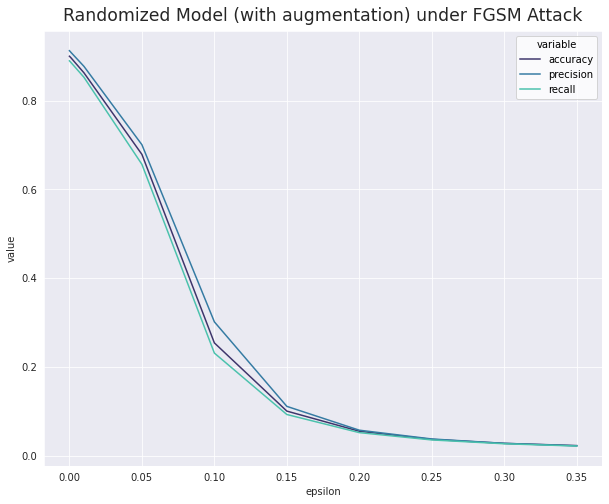

In [78]:
attack(
    model=cnn,
    X_test_d=X_test_fgsm_d,
    y_true=y_test_origin,
    attack_name='FGSM',
    model_name='Randomized Model (with augmentation)',
    xlabel='epsilon'
)

# Setup augmented data generator

In [ ]:
augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='constant',
    cval=0,
    height_shift_range=3,
    width_shift_range=3,
    # shear_range=20,
    # rotation_range=20,
    # zoom_range=0.2,
    data_format='channels_last',
    # rescale=1.0/255,
)

## Visualise the data augmentations

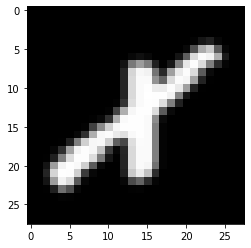

In [ ]:
# original
img = X_train_origin[100]
plt.imshow(img.reshape((28, 28)), cmap=plt.get_cmap('gray'))

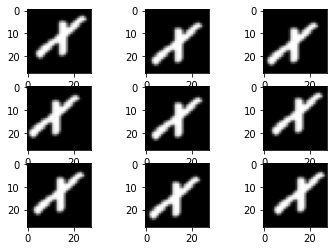

In [ ]:
# randomised
samples = np.expand_dims(img, 0)

iter = augmentation_generator.flow(samples, batch_size=2)

for i in range(9):
  plt.subplot(330 + 1 + i)
  batch = iter.next()
  image = batch[0]
  plt.imshow(
      image.reshape((28,28)), 
      cmap=plt.get_cmap('gray'),
  )
plt.show()

## Visualise the data augmentations

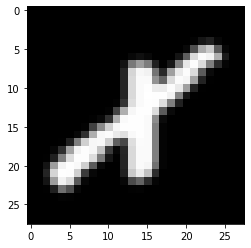

In [ ]:
# original
img = X_train_origin[100]
plt.imshow(img.reshape((28, 28)), cmap=plt.get_cmap('gray'))

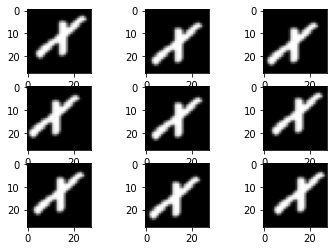

In [ ]:
# randomised
samples = np.expand_dims(img, 0)

iter = augmentation_generator.flow(samples, batch_size=2)

for i in range(9):
  plt.subplot(330 + 1 + i)
  batch = iter.next()
  image = batch[0]
  plt.imshow(
      image.reshape((28,28)), 
      cmap=plt.get_cmap('gray'),
  )
plt.show()